# Präsentation

https://oskarstalberg.com/game/wave/wave.html

Überblick:
1. Einleitung - Was ist Wave Function Collapse
2. Zwei Varianten - Das Original, und die Verallgemeinerung
3. High Level Überblick über die zwei Stages des Algorithmus
    1. a
4. Erklärung des original Algorithmus
    
5. Erklärung des Verallgemeinerten Algorithmus

Der Algorithmus besteht aus zwei phasen:
1. Beschaffung der Metadaten (Content Segmente, und Nachbarschafts regeln)
2. Füllen aller Slots mit den Content Segmenten, unter beachtung der Nachbarschafts regeln.

Wave Function Collapse is an algorithm in the family of Procedural Generation Algorithms.  
The purpose of the original version is to generate images on a 2D pixel grid by relying solely on local adjecency rules infered from an example image.  

This original version has seen a number of modifications and extensions over time, including but not limited to:  
- Generalizing to 3D (or any other dimension, although that is not as practical)
- Become content agnostic, meaning it doesn't work on pixel values, but abstract "tiles"
- changing how adjecency rules are gathered
- including global or regional constraints like generating a certain feature exactly once in the entire output

## Zwei Varianten des WFC Algorithmus

### Kernel Based

Example: Caves of Qud

```python
def KernelWFC(InputImage:Image,
              KernelSize:(int, int),
              OutputSize:(int, int),
              WrapInput :bool,
              WrapOutput:bool,
              Symmetries:int,
              FrequencyHints:bool) -> Image:
    ...
```

Loading:  
- Takes an existing image as input
- Extracts all patches of configurable size (usually 3x3) from the input image

Generating:
- Picks 

The Tiles and the neighboorhood rules can be generated from an existing example.  
1. For that purpose the image (2D) or mesh (3D) is analyzed for equally sized cells which appear multiple times (in essence what a compression algorithm would do).
2. The szene is then split into these discrete chunks, and the neighboors of each chunk are analysed for infer neighboorhood rules.  
3. The downside here is that variations that did not appear in the input, but would be consistent with its rules will not appear in the output. The output will however look quite similar structurally to the input.

```python
def Run():
    PatternsFromSample()
    BuildPropagator() # auch genannt index
    while not finished:
        Observe()
        Propagate()
    OutputObservations()
```

```python
def Observe(coefficient_matrix):
    FindLowestEntropy()
    if there is a contradiction: throw an error and quit
    if all cells are at entropy 0:
        processing is complete
        return CollapsedObservations()
    else:
        Choose a pattern by a random sample, weighted by the
            pattern frequency in the source data
        Set the boolean array in this cell to false, except
            for the chosen pattern
```

```python
def FindLowestEntropy(coefficient_matrix):
    Return the cell that has the lowest greater-than-zero
        entropy, defined as:
        A cell with one valid pattern has 0 entropy
        A cell with no valid patterns is a contradiction
        else: the entropy is based on the sum of the frequency
            that the patterns appear in the source data, plus
            Use some random noise to break ties and
                near-ties.
```

```python
def Propagate(coefficient_matrix): # flood-fill
    while more cells are left to be update:
        for each neighboring cell:
            for each pattern that is still potentially valid:
                Compare this location in the pattern with the cell's values
                    if this point in the pattern no longer matches:
                        Set the array in the wave to false for this pattern
                        Flag this cell as needing to be updated in the next iteration
```

```python
def OutputObservations(coefficient_matrix):
    for each cell:
        Set observed value to the average of the color value
            of this cell in the pattern for the remaining valid patterns
    return the observed values as an output image
```

### Tile Based

Example: bad north, townscaper

```python
def TileWFC(AdjacencyRules:dict,
            OutputSize:(int, int),
            WrapOutput:bool,
            Symmetries:int,
            FrequencyHints:bool) -> Image:
    ...
```

1. Have a set of tiles that will make up the world, together with rules which tiles fit next to each other.
2. Pick a random empty tile in the world and randomly choose one of the tiles to fill it with
3. Now propagate the neighboorhood rules to all cells, eliminating possibilities for which tiles can be placed where
4. Chose the empty tile with the lowest number of possibilities, and randomly pick one of the possible tiles to place there
5. Repeate the above steps until there are no more empty tiles.
6. Ein Backtracking ist evtl. notwendig wenn der algorithmus an einen punkt gelangt wo eine zelle keine möglichen tiles hat die dort plaziert werden könnten.
7. Wenn die regeln nicht gut gewählt sind, kann es (glaube ich) dazu kommen, dass bestimmte features nie generiert werden, oder dass man an einem Punkt ankommt wo eine zelle keine möglichen ausprägungen mehr hat.

## Algorithm

## Global and local constraints

#### Global restarts vs backtracking

## Sources

- [1] Superpositions, Sudoku, the Wave Function Collapse algorithm.
    - https://youtu.be/2SuvO4Gi7uY
    - [Martin Donald](https://www.youtube.com/c/MartinDonald)
- [2] Why I'm Using Wave Function Collapse for Procedural Terrain | Unity Devlog
    - https://youtu.be/20KHNA9jTsE
    - [DV Gen](https://www.youtube.com/channel/UCt9Rb0CWT8-bbsJtUOg6BsA)
- [3] Playing With The Wave Function Collapse Algorithm
    - https://youtu.be/GeBI9Bvo9oM
    - [Giant Bee](https://www.youtube.com/channel/UCMmnI7Fm3CglKF2AIpvGrLg)
- [4] How Townscaper Works: A Story Four Games in the Making | AI and Games
    - https://youtu.be/_1fvJ5sHh6A
    - [AI and Games](https://www.youtube.com/c/AIGamesSeries)
- [5] Wave Function Collapse Tutorial Unity (Playlist)
    - https://youtube.com/playlist?list=PLcRSafycjWFeKAS40OdIvhL7j-vsgE3eg
    - [Sunny Valley Studio](https://www.youtube.com/c/SunnyValleyStudio)
- [6] EPC2018 - Oskar Stalberg - Wave Function Collapse in Bad North
    - https://youtu.be/0bcZb-SsnrA
    - [BUas Games](https://www.youtube.com/channel/UC60WsaNESJpLHZ5Hjpuy7UQ)
- [7] Markov Chain based Wave Function Collapse
    - https://youtu.be/0W7yCuwlrbU
    - [Pronay Peddiraju](https://www.youtube.com/channel/UCZ6Pq8Ko3EUoVapphx8Pl0g)
- [8] Tile-Based Map Generation using Wave Function Collapse in 'Caves of Qud'
    - https://youtu.be/AdCgi9E90jw
    - [GDC](https://www.youtube.com/channel/UC0JB7TSe49lg56u6qH8y_MQ)
- [9] WaveFunctionCollapse is Constraint Solving in the Wild
    - https://adamsmith.as/papers/wfc_is_constraint_solving_in_the_wild.pdf
    - Isaac Karth, Adam M. Smith (2017)
- [10] Townscaper Announcement Trailer
    - https://youtu.be/QtVkteAS15M
    - [Raw Fury](https://www.youtube.com/channel/UCbyFV2lioP9a1YlUC4gm6xA)
- [11] Interactive Wave Function Collapse Demo
    - https://oskarstalberg.com/game/wave/wave.html
    - [Oskar Stålberg](oskarstalberg.com)
- [12] Original Wave Function Collapse GitHub Repo
    - https://github.com/mxgmn/WaveFunctionCollapse
    - [Maxim Gumin](https://github.com/mxgmn)
- [13] Procedural Generation with Wave Function Collapse
    - https://www.gridbugs.org/wave-function-collapse/
    - [Grid Bugs](https://www.gridbugs.org/)

# Code

In [ ]:
%matplotlib notebook

In [ ]:
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from copy import deepcopy
from pprint import pprint

In [ ]:
choice = np.random.choice

## Visualization

In [ ]:
import cv2
import os
import re
import shutil
from pathlib import Path
from IPython.display import clear_output
import numpy as np
import ctypes
from ctypes import *
from collections import deque
import time

### Events

In [ ]:
print([i for i in dir(cv2) if 'EVENT' in i])

['EVENT_FLAG_ALTKEY', 'EVENT_FLAG_CTRLKEY', 'EVENT_FLAG_LBUTTON', 'EVENT_FLAG_MBUTTON', 'EVENT_FLAG_RBUTTON', 'EVENT_FLAG_SHIFTKEY', 'EVENT_LBUTTONDBLCLK', 'EVENT_LBUTTONDOWN', 'EVENT_LBUTTONUP', 'EVENT_MBUTTONDBLCLK', 'EVENT_MBUTTONDOWN', 'EVENT_MBUTTONUP', 'EVENT_MOUSEHWHEEL', 'EVENT_MOUSEMOVE', 'EVENT_MOUSEWHEEL', 'EVENT_RBUTTONDBLCLK', 'EVENT_RBUTTONDOWN', 'EVENT_RBUTTONUP']


OpenCV Mouse Event Docs  
https://docs.opencv.org/3.4/d0/d90/group__highgui__window__flags.html  

### Window

In [ ]:
def open_window(WindowName, Width, Height):
    cv2.namedWindow(WindowName,cv2.WINDOW_NORMAL | cv2.WINDOW_KEEPRATIO | cv2.WINDOW_GUI_EXPANDED)
    cv2.resizeWindow(WindowName, Width, Height)
    cv2.moveWindow(WindowName, 1000,200)
    cv2.setWindowProperty(WindowName, cv2.WND_PROP_TOPMOST, 1)

In [ ]:
def get_mouse_event_queue(WindowName):
    "Convert Mouse Callback -> FIFO Queue"
    MouseEventQueue = deque()
    def mouse_callback(Event, X, Y, Flags, Param):
        MouseEventQueue.append((Event, X, Y, Flags, Param))
    cv2.setMouseCallback(WindowName, mouse_callback)
    return MouseEventQueue

In [ ]:
class EXITCODES:
    CONTINUE = 0
    QUIT     = 1

In [ ]:
# class ACTIONS:
#     CONTINUE
#     QUIT
    

In [ ]:
class STATE:
    WindowName:str   = 0
    WindowWidth:int  = 0
    WindowHeight:int = 0
    
    ImageGenerator:iter = 0
    Images:list = 0
    
    AppStartTime:float = 0
    
    RenderState:dict = 0

In [ ]:
def handle_keypresses():
    ExitCode = EXITCODES.CONTINUE
    Key = cv2.pollKey()
    while Key != -1:
        # NOTE: Process keys here
        Key = Key & 0xFF
        ExitCode = KeyBinds.get(Key, ExitCode) # no match -> no change
        Key = cv2.pollKey()
    return ExitCode

In [ ]:
def handle_mouseinput(MouseEvents):
    while(1):
        try: Event, X, Y, Flags, Param = MouseEvents.popleft()
        except IndexError: break # MouseEvents is Empty
        if Event == cv2.EVENT_MOUSEMOVE:
            pass
        elif Event == cv2.EVENT_LBUTTONDOWN:
            pass
        elif Event == cv2.EVENT_LBUTTONUP:
            pass
        elif Event == cv2.EVENT_RBUTTONDOWN:
            pass
        elif Event == cv2.EVENT_RBUTTONUP:
            pass

In [ ]:
def render(State, Buffer, DeltaTime):
    if State.RenderState == 0: State.RenderState = dict()
    if State.Images      == 0: State.Images      = list()
    try: State.Images.append(next(State.ImageGenerator))
    except StopIteration: pass
    # Get the next image
    if 'FrameID' in State.RenderState:
        FrameID = State.RenderState['FrameID']
    else:
        State.RenderState['FrameID'] = 0
        FrameID = 0
    if FrameID >= len(State.Images): FrameID = 0
    Frame = State.Images[FrameID]
    FrameID += 1
    State.RenderState['FrameID'] = FrameID
    
    # Copy image to Buffer
    FrameHeight, FrameWidth, *_ = Frame.shape
    Buffer[0:FrameHeight, 0:FrameWidth] = Frame

In [ ]:
def main(ImageGenerator):
    "Displays Images from ImageGenerator"
    ExitCode = EXITCODES.CONTINUE
    
    State = STATE()
    State.WindowName   = 'WaveFunctionCollapse'
    State.WindowWidth  = 1000
    State.WindowHeight = 1000
    State.ImageGenerator = ImageGenerator
    
    Buffer = np.zeros((State.WindowHeight, State.WindowWidth, 3), np.uint8)
    open_window(State.WindowName, State.WindowWidth, State.WindowHeight)
    MouseEventQueue = get_mouse_event_queue(State.WindowName)

    # Render loop
    TargetFrameDuration = 1 / 30
    AppStartTime = FrameStartTime = time.time()
    State.AppStartTime = AppStartTime
    while(1):
        # I/O
        ExitCode = handle_keypresses()
        handle_mouseinput(MouseEventQueue)
        # Render
        render(State, Buffer, TargetFrameDuration)
        # Exit Condition
        if   ExitCode == EXITCODES.QUIT    : break
        elif ExitCode == EXITCODES.CONTINUE: pass
        else: print(f'Unsupported Exit Code: {ExitCode}')
        # Frame Timing
        # TODO: This timing code is probably bogus.
        #       We need to calculate how much time we expect to pass before the next frame gets flipped,
        #       and calculate when to skip a frame / catch up the simulation if we skip a frame
        FrameEndTime = time.time()
        FrameDuration = FrameEndTime - FrameStartTime
        TargetDurationOffset = TargetFrameDuration - FrameDuration
        if TargetDurationOffset > 0: time.sleep(TargetDurationOffset)
        FrameStartTime = time.time()
        # Blip
        cv2.imshow(State.WindowName, Buffer)
    cv2.destroyWindow(State.WindowName)

In [ ]:
cv2.resize()

In [ ]:
KeyBinds = {ord('q'): EXITCODES.QUIT,
           }
KeyBinds

{113: 1}

In [ ]:
# TODO: This still requires some major construction. Maybe look at nbgame for some inspiration.

In [ ]:
# TODO: What is it that this code should do?
#       Display an image, animate multiple steps of WFC, allow interaction to change parameters?
#       What else? should it do all those things? is there an easier way to do them?
#       What is the least effort required to get this up and running.
#       Maybe push the difficult decisions to later, and just do the obvious thing first.
#       No need to overcomplicate things right away.

In [ ]:
# TODO: I want to use this to render
#       main() should open a window,
#       and then call something that does WFC step by step, allowing main() to render the intermediate images.
#       WFC should probably be a generator

In [ ]:
def testGenerator():
    width, height = 500, 500
    offset = 2
    for i in range(30):
        yield np.arange(width*height*3).reshape(width, height, 3) + (offset * i)

In [ ]:
main(testGenerator())

## 1D

In [ ]:
def show_line(Line):
    %matplotlib inline
    plt.axis('off')
    plt.imshow([Line])

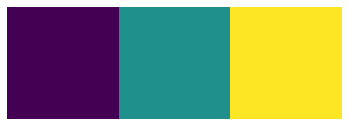

In [ ]:
show_line([1, 2, 3])

In [ ]:
def animate_lines(Lines):
    %matplotlib notebook
    fig, ax = plt.subplots()
    ax.axis('off')
    img = ax.imshow([Lines[-1]], animated=True)
    
    def animate(frame, *fargs):
        img.set_data([frame])
        
    return animation.FuncAnimation(fig, animate, frames=Lines, interval=500, repeat=True)

<IPython.core.display.Javascript object>


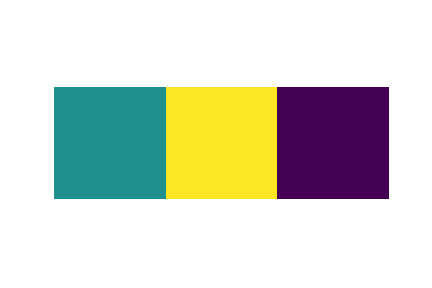

In [ ]:
animate_lines([
    [0, 0, 0],
    [1, 2, 3],
    [2, 3, 1],
    [3, 1, 2],
]);

### Complete Wave Function Collapse 1D

In [ ]:
def D1_WaveFunctionCollapse(N, PossibleValuesRules) -> (list, list):
    AllLines = list()
    NumberOfPossibleValues = len(PossibleValuesRules)
    PossibleValues         = list(PossibleValuesRules.keys())
    PossibleValuesIdxs     = np.arange(NumberOfPossibleValues)
    Line             = np.zeros(shape=N, dtype=int)
    AllLines.append(deepcopy(Line))
    WaveFunction     = np.ones(shape=(N, NumberOfPossibleValues), dtype=bool)
    LineHasCollapsed = np.zeros(shape=N, dtype=bool)
    
    X = choice(N) # Choose initial cell to collapse
    while True:
        PossibleIdxForX = PossibleValuesIdxs[WaveFunction[X]]
        assert len(PossibleIdxForX) > 0
        ChoiceIdxForX   = choice(PossibleIdxForX) # Choose what value to collapse to, among the remaining possible ones.
        Line[X]         = PossibleValues[PossibleValuesIdxs[ChoiceIdxForX]] # Apply choice to cell
        AllLines.append(deepcopy(Line))
        
        LineHasCollapsed[X] = True
        WaveFunction[X]     = False # numpy broadcasting
        
        WaveFunctionHasChanged = True
        while WaveFunctionHasChanged: # execute at least once
            WaveFunctionHasChanged = False
            for i in range(0, N):
                if LineHasCollapsed[i]:
                    # print(f'{i} Collapsed')
                    continue # Dont update the wavefunction of a cell that has already collapsed
                CurrentElement      = Line[i]
                CurrentWaveFunction = WaveFunction[i]
                NewWaveFunction     = np.ones_like(CurrentWaveFunction)
                
                def check_element(idx):
                    "Checks what values are permitted at the current element, based on what is present at this neighboor."
                    OtherElement, OtherWaveFunction = Line[idx], WaveFunction[idx]
                    if LineHasCollapsed[idx]:
                        AllowedValues = PossibleValuesRules[OtherElement]
                    else:
                        AllowedValues = [Value for (V, W) in zip(PossibleValues, OtherWaveFunction) for Value in PossibleValuesRules[V] if W]
                    for ValueIdx, Value in enumerate(PossibleValues):
                        if Value in AllowedValues:
                            # if another cell has already made this value impossible, it can't be made possible again here.
                            NewWaveFunction[ValueIdx] &= True
                        else:
                            NewWaveFunction[ValueIdx] = False

                if i > 0  : check_element(i-1)
                if i < N-1: check_element(i+1)
                NumberOfPossibleValues = sum(NewWaveFunction)
                assert NumberOfPossibleValues != 0, f'{i} {WaveFunction}'
                if NumberOfPossibleValues == 1: # Collapse this element
                    Line[i]                = PossibleValues[PossibleValuesIdxs[NewWaveFunction][0]]
                    AllLines.append(deepcopy(Line))
                    LineHasCollapsed[i]    = True
                    WaveFunction[i]        = False # numpy broadcasting
                    WaveFunctionHasChanged = True
                else:
                    WaveFunction[i] = NewWaveFunction
                    WaveFunctionHasChanged |= any(CurrentWaveFunction != NewWaveFunction)
                # print(i, CurrentWaveFunction, NewWaveFunction)
        
        NumberOfPossibleStates = WaveFunction.sum(axis=1)
        # Get the field with the lowest number of non-zero (non-collapsed) states.
        # If there are multiple fields, pick one of those at random.
        RemainingUncertainFields = np.flatnonzero(LineHasCollapsed == False)
        if len(RemainingUncertainFields) == 0: break # STOP condition
        
        # There are two way of calculating what the number of least, non-zero, possibilities is:
        # LeastNumberOfRemainingStates = np.min(NumberOfPossibleStates,
        #                                       where=(LineHasCollapsed == False),
        #                                       initial=NumberOfPossibleValues)

        LeastNumberOfRemainingStates = np.min(NumberOfPossibleStates[RemainingUncertainFields])

        # Choose which cell to collapse next
        X = choice(np.flatnonzero(NumberOfPossibleStates == LeastNumberOfRemainingStates))
    return Line, AllLines

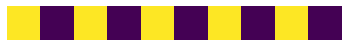

In [ ]:
N = 10
# PossibleValuesRules = {
#     0: (1, 3,),
#     1: (0,),
#     2: (1,),
#     3: (2,3)
# }
PossibleValuesRules = {
    0: (1,),
    1: (0,),
}
Line, AllLines = D1_WaveFunctionCollapse(N, PossibleValuesRules)
show_line(Line)
# animate_lines(AllLines);

In [ ]:
AllLines

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0]),
 array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0]),
 array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0]),
 array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0]),
 array([0, 0, 1, 0, 1, 0, 1, 0, 1, 0]),
 array([0, 0, 1, 0, 1, 0, 1, 0, 1, 0]),
 array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0])]

## 2D

In [ ]:
# TODO: replace matplotlib image show with something else, something more flexible. Maybe custom rendering via opencv

In [ ]:
def show_image(Image, GridLines:int=0, LineColor:str='black'):
    "GridLines is the number of pixels between each gridline in the X and Y direction.\n"\
    "Setting GridLines to 0 turns off the grid and axis.\n"\
    "LineColor is the color of the gridlines. Only used if GridLines is > 0."
    %matplotlib inline
    plt.imshow(Image)
    if not GridLines:
        plt.axis('off')
    else:
        plt.xticks(np.arange(-.5, Image.shape[1], GridLines))
        plt.yticks(np.arange(-.5, Image.shape[0], GridLines))
        plt.grid(color=LineColor, linewidth=4)

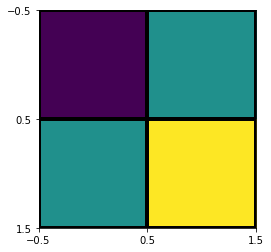

In [ ]:
show_image(np.array([[1, 2], [2, 3]]), GridLines=1)

In [ ]:
def animate_images(Images, GridLines:int=0, LineColor:str='black'):
    "GridLines is the number of pixels between each gridline in the X and Y direction.\n"\
    "Setting GridLines to 0 turns off the grid and axis.\n"\
    "LineColor is the color of the gridlines. Only used if GridLines is > 0."
    %matplotlib notebook
    fig, ax = plt.subplots()
    img = ax.imshow(Images[-1], animated=True)
    if not GridLines:
        ax.axis('off')
    else:
        # TODO: For some stupid reason, the gridlines only work under specific circumstances
        ax.set_xticks(np.arange(-.5, Images[-1].shape[1], GridLines))
        ax.set_yticks(np.arange(-.5, Images[-1].shape[0], GridLines))
        ax.grid(color=LineColor, linewidth=4)
    
    def animate(frame, *fargs):
        img.set_data(frame)
    
    return animation.FuncAnimation(fig, animate, frames=Images, interval=500, repeat=True)

<IPython.core.display.Javascript object>


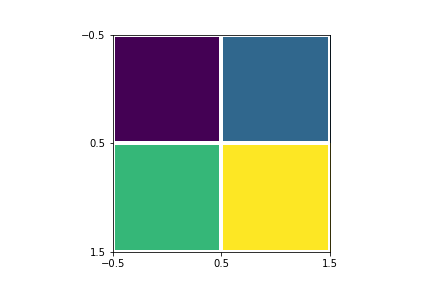

In [ ]:
animate_images(np.array([
    [[0, 0], [0, 0]],
    [[0, 0], [0, 1]],
    [[0, 0], [1, 2]],
    [[0, 1], [2, 3]],
    [[1, 2], [3, 4]],
]), GridLines=1, LineColor='white');

In [ ]:
def verify_rules_2D(Rules):
    for k, v in Rules.items():
        for Direction, AllowedValues in v.items():
            OppositeDirection = {'U':'D', 'D':'U', 'L':'R', 'R':'L'}[Direction]
            for Value in AllowedValues:
                assert (k in Rules[Value][OppositeDirection]), \
                f'{k} "{Direction}" allows {AllowedValues}, '\
                f'but {Value} "{OppositeDirection}" only allows {Rules[Value][OppositeDirection]}'

In [ ]:
def Neighbours(X, Y, N, M) -> (str, int, int):
    'The Letter is the direction you need to go to get back to the original coordinates'
    # {'L':0,'R':1,'U':2,'D':3}
    if (X - 1) >= 0      : yield (3, X - 1, Y    ) # 'D'
    if (X + 1) <= (N - 1): yield (2, X + 1, Y    ) # 'U'
    if (Y - 1) >= 0      : yield (1, X    , Y - 1) # 'R'
    if (Y + 1) <= (M - 1): yield (0, X    , Y + 1) # 'L'
# set(Neighbours(3, 1, 10, 10))

In [ ]:
def verify_rules_matrix_2D(RulesMatrix):
    OppositeDirection = {2:3, 3:2, 0:1, 1:0}
    for (ThisTile, TileRules) in enumerate(RulesMatrix):
        for (Direction, Rule) in enumerate(TileRules):
            for (OtherTile, IsAllowed) in enumerate(Rule):
                OtherDirection = OppositeDirection[Direction]
                OtherRule      = RulesMatrix[OtherTile][OtherDirection]
                OtherIsAllowed = OtherRule[ThisTile]
                assert IsAllowed == OtherIsAllowed, \
                f'Tile {ThisTile} and Tile {OtherTile} disagree on whether they can be next to each other.\n\t\t' \
                f'The Rule values should be identical at the following directions and indices:\n\t\t'\
                f'Tile {ThisTile} in direction {Direction} at index {OtherTile}, and '\
                f'Tile {OtherTile} in direction {OtherDirection} at index {ThisTile}:\n\t\t'\
                f'Tile {ThisTile}{[Direction]}: {Rule}[{OtherTile}] = {IsAllowed}\n\t\t'\
                f'Tile {OtherTile}{[OtherDirection]}: {OtherRule}[{ThisTile}] = {OtherIsAllowed}'

In [ ]:
# Convert a Wave Function to a render-able Image

def assemble_tiles(IntermediateImage):
    "Takes in a N x M x V x W x *_ Matrix and reshapes it to N*V x M*W x *_. "\
    "Basically it assembles a bunch of image patches into one image."
    return np.hstack(np.hstack(IntermediateImage))

def ImageFromPartialWaveFunction(N:int, M:int, Wave, TileMatrix, AsType:type=float):
    "Generate an Image from a partially collapsed WaveFunction by averaging over possible Tiles"
    ImageW = [[list() for _ in range(M)] for _ in range(N)] # N x M x Variable dimensional list
    for (X, Y, Vs) in np.argwhere(Wave):
        ImageW[X][Y].append(TileMatrix[Vs])
    ImageW2 = np.array([[np.mean(L2, axis=0) for L2 in L1] for L1 in ImageW]) # Average over the variable dimension
    ImageW3 = assemble_tiles(ImageW2)
    return ImageW3.astype(AsType)

def ImageFromCollapsedWaveFunction(N:int, M:int, Wave, TileMatrix, AsType:type=float):
    "Generate an Image from a collapsed WaveFunction."
    _, _, ImageValues = np.nonzero(Wave)
    assert ImageValues.shape == (N * M,)
    TileIndices = ImageValues.reshape(N, M)
    Image = assemble_tiles(TileMatrix[TileIndices])
    return Image.astype(AsType)

## Complete 2D WFC

In [ ]:
def WFC_2D(N:int, M:int, RulesMatrix):
    Wave = np.ones (shape=(N, M, len(RulesMatrix)), dtype=bool)
    X, Y = choice(N), choice(M) # Initial Cell Choice
    # TODO: Do a pre-pass here to handle global conditions? What if a tile can't be placed at the edge?
    # NOTE: Currently we don't treat the edge in and special way
    while True:
        # NOTE: Assign a Tile (from those available at this cell) to chosen Cell
        TileChoice              = choice(np.flatnonzero(Wave[X, Y])) # This assumes Tiles are stored/indexed like a list
        Wave [X, Y]             = False # Numpy Broadcasting
        Wave [X, Y][TileChoice] = True # This is used in the floodfill part to figure out what rules apply
        # NOTE: Floodfill to update all Cells whose Neighbours have changed
        CellsToCheck = set(Neighbours(X, Y, N, M))
        while len(CellsToCheck) > 0:
            NewCellsToCheck = set()
            for (_, K, J) in CellsToCheck:
                # NOTE: Check all Rules of this Cell, and modify Wave accordingly.
                CurrentWave    = Wave[K, J]
                CurrentWaveNew = np.ones_like(CurrentWave)
                if CurrentWave.sum() <= 1: continue # Only one remaining state -> this cell is already collapsed
                # TODO: Technically we only need to check this for neighbours that have changed,
                #       but keeping track of that seems like it might be more effort than just checking all neighbours.
                # TODO: This loop can probably also be done in numpy
                for (D, U, V) in Neighbours(K, J, N, M):
                    # NOTE: A vector of which Tiles this Neighbour allows in the Cell we're updating
                    # If any of the tiles possible at this neighbour allow a certain tile to be placed in the current cell,
                    # then that tile can't be excluded from the wave function of possible states yet.
                    # If no possible tile at this neighbour can be placed next to a certain tile,
                    # then that tile must be removed from the wavefunction of the current cell.
                    OtherConstraint = RulesMatrix[np.flatnonzero(Wave[U, V])][:, D].any(axis=0)
                    # Logical AND -> one neighbour disallowing a tile means that tile cant be used at all in current cell
                    CurrentWaveNew &= OtherConstraint
                if np.sum(CurrentWaveNew) == 0: raise Exception(f'Arrived at an unsolvable solution. {K, J}')
                if np.any(CurrentWave != CurrentWaveNew):
                    NewCellsToCheck.update(Neighbours(K, J, N, M))
                Wave[K, J] = CurrentWaveNew
            CellsToCheck = NewCellsToCheck
        CellEntropy = Wave.sum(axis=-1) # Number of remaining States per cell
        if np.all(CellEntropy == 1): break # STOP Condition
        yield deepcopy(Wave)
        # NOTE: Select next Cell based on lowest Entroy
        LowestUncollapsedEntropy = np.min(CellEntropy[CellEntropy != 1])
        assert LowestUncollapsedEntropy > 1, f'1 means the cell should already be collapsed, and < 0 should be impossible.'
        OptionsForNextCell = np.argwhere(CellEntropy == LowestUncollapsedEntropy) # Un-collapsed Cells with the lowest Entropy
        X, Y = OptionsForNextCell[choice(len(OptionsForNextCell))]
    yield Wave

In [ ]:
Tiles = [
    [[0, 1], [0, 0]],
    [[0, 0], [1, 1]],
    [[1, 0], [1, 0]],
    [[0, 0], [0, 0]],
]
TileMatrix = np.array(Tiles); TileMatrix.shape, TileMatrix

((4, 2, 2),
 array([[[0, 1],
         [0, 0]],
 
        [[0, 0],
         [1, 1]],
 
        [[1, 0],
         [1, 0]],
 
        [[0, 0],
         [0, 0]]]))

In [ ]:
Rules = {
    0: {
        'L' : (2,3),
        'R' : (2,3),
        'U' : (1,3),
        'D' : (1,2,3),
    },
    1: {
        'L' : (1,3),
        'R' : (1,2,3),
        'U' : (0,3),
        'D' : (0,3),
    },
    2: {
        'L' : (0,1,3),
        'R' : (0,3),
        'U' : (0,3),
        'D' : (3,),
    },
    3: {
        'L' : (0,1,2),
        'R' : (0,1,2),
        'U' : (0,1,2),
        'D' : (0,1,2),
    },
}
verify_rules_2D(Rules)

In [ ]:
def rule_to_vector(TileAmount, Rule):
    return [(i in Rule) for i in range(TileAmount)]
def rules_to_np(Rules):
    TileAmount = len(Rules)
    return np.array([[rule_to_vector(TileAmount, Rules[i][d]) for d in ('L', 'R', 'U', 'D')] for i in range(TileAmount)])

RulesMatrix = rules_to_np(Rules); RulesMatrix.shape

(4, 4, 4)

In [ ]:
verify_rules_matrix_2D(RulesMatrix)

In [ ]:
N, M = 10, 10
AllWaves = list(WFC_2D(N, M, RulesMatrix))
AllWaves = [ImageFromPartialWaveFunction(N, M, W, TileMatrix) for W in AllWaves]

<IPython.core.display.Javascript object>


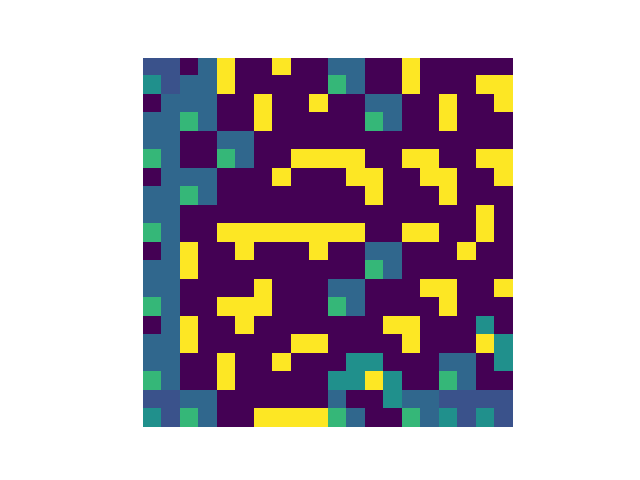

In [ ]:
animate_images(AllWaves);

## Edge Based Automatic Rule Inference from Tiles

In [ ]:
WHITE = np.array([255, 255, 255])
RED   = np.array([255,   0,   0])
GREEN = np.array([  0, 255,   0])
BLUE  = np.array([  0,   0, 255])
def interpolate_colors(ColorA, ColorB): return ((ColorA + ColorB) // 2).astype(int)

In [ ]:
def generate_triangle_masks(V, W):
    LowerTriangle = np.tri(V, W, 0, dtype=bool)
    UpperTriangle = LowerTriangle.T
    FlippedLowerTriangle = np.fliplr(LowerTriangle)
    FlippedUpperTriangle = np.fliplr(UpperTriangle)
    Up    = UpperTriangle & FlippedUpperTriangle
    Right = UpperTriangle & FlippedLowerTriangle
    Down  = LowerTriangle & FlippedLowerTriangle
    Left  = LowerTriangle & FlippedUpperTriangle
    return Up, Right, Down, Left

In [ ]:
def generate_triangle_tile(V, W, UpColor, RightColor, DownColor, LeftColor):
    Up, Right, Down, Left = generate_triangle_masks(V, W)
    Tile = np.zeros(shape=(V, W, 3), dtype=int)
    
    UpRightInterfaceColor   = interpolate_colors(UpColor  , RightColor)
    DownRightInterfaceColor = interpolate_colors(DownColor, RightColor)
    DownLeftInterfaceColor  = interpolate_colors(DownColor, LeftColor)
    UpLeftInterfaceColor    = interpolate_colors(UpColor  , LeftColor)
    
    Tile[Up]    = UpColor
    Tile[Right] = RightColor
    Tile[Down]  = DownColor
    Tile[Left]  = LeftColor
    
    Tile[Up & Right]   = UpRightInterfaceColor
    Tile[Down & Right] = DownRightInterfaceColor
    Tile[Down & Left]  = DownLeftInterfaceColor
    Tile[Up & Left]    = UpLeftInterfaceColor
    return Tile

In [ ]:
V, W = (120, 120)

In [ ]:
# https://en.wikipedia.org/wiki/Wang_tile
# https://en.wikipedia.org/wiki/Wang_tile#/media/File:Wang_11_tiles.svg

In [ ]:
Tile01 = generate_triangle_tile(V, W, RED, RED, RED, GREEN)

In [ ]:
Tile02 = generate_triangle_tile(V, W, BLUE, RED, BLUE, GREEN)

In [ ]:
Tile03 = generate_triangle_tile(V, W, RED, GREEN, GREEN, GREEN)

In [ ]:
Tile04 = generate_triangle_tile(V, W, WHITE, BLUE, RED, BLUE)

In [ ]:
Tile05 = generate_triangle_tile(V, W, BLUE, BLUE, WHITE, BLUE)

In [ ]:
Tile06 = generate_triangle_tile(V, W, WHITE, WHITE, RED, WHITE)

In [ ]:
Tile07 = generate_triangle_tile(V, W, RED, GREEN, BLUE, WHITE)

In [ ]:
Tile08 = generate_triangle_tile(V, W, BLUE, WHITE, BLUE, RED)

In [ ]:
Tile09 = generate_triangle_tile(V, W, BLUE, RED, WHITE, RED)

In [ ]:
Tile10 = generate_triangle_tile(V, W, GREEN, GREEN, BLUE, RED)

In [ ]:
Tile11 = generate_triangle_tile(V, W, RED, WHITE, RED, GREEN)

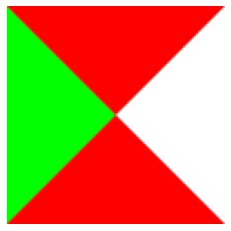

In [ ]:
show_image(Tile11)

In [ ]:
Tiles = [Tile01, Tile02, Tile03, Tile04, Tile05, Tile06, Tile07, Tile08, Tile09, Tile10, Tile11]

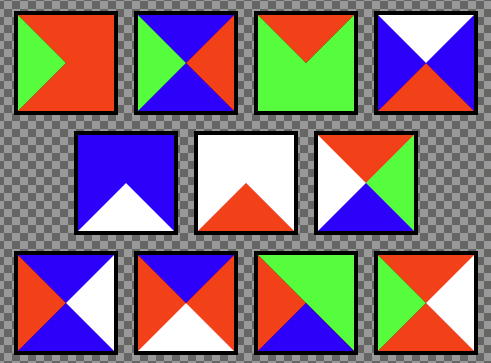

In [ ]:
TilesMatrix = np.array(Tiles); TilesMatrix.shape

(11, 120, 120, 3)

In [ ]:
# NOTE: This Matrix is created with the last to axis swapped, which is then corrected at the end.
#       The reason for doing this is that it's a lot easier to program,
#       because now we can unroll the check for the directions for each tile (since directions are always only 4).
#       If we did it the other way, we'd need another loop and conditions to handle the different cases.
RulesList = []
# 'L', 'R', 'U', 'D'
for Tile in TilesMatrix:
    CurrentRules = []
    ShapeX, ShapeY, *_ = Tile.shape
    LeftColor  = Tile[ShapeX//2,         0]
    RightColor = Tile[ShapeX//2,        -1]
    UpColor    = Tile[        0, ShapeY//2]
    DownColor  = Tile[       -1, ShapeY//2]
    
    for OtherTile in TilesMatrix:
        OtherShapeX, OtherShapeY, *_ = OtherTile.shape
        assert ShapeX == OtherShapeX and ShapeY == OtherShapeY
        OtherLeftColor  = OtherTile[OtherShapeX//2,         0]
        OtherRightColor = OtherTile[OtherShapeX//2,        -1]
        OtherUpColor    = OtherTile[        0, OtherShapeY//2]
        OtherDownColor  = OtherTile[       -1, OtherShapeY//2]
        CurrentRule = np.array([LeftColor == OtherRightColor, RightColor == OtherLeftColor, 
                                UpColor   == OtherDownColor , DownColor  == OtherUpColor   ],
                               dtype=bool).all(axis=-1)
        CurrentRules.append(CurrentRule)
    RulesList.append(CurrentRules)
RulesMatrix = np.swapaxes(np.array(RulesList), -1, -2); RulesMatrix.shape

(11, 4, 11)

In [ ]:
verify_rules_matrix_2D(RulesMatrix)

In [ ]:
N, M = 10, 10
AllWaves = list(WFC_2D(N, M, RulesMatrix))
AllWaves = [ImageFromPartialWaveFunction(N, M, W, TilesMatrix, int) for W in AllWaves]

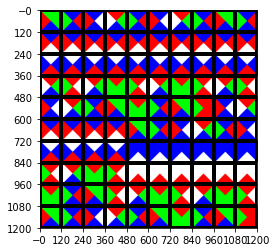

In [ ]:
show_image(AllWaves[-1], GridLines=120)

<IPython.core.display.Javascript object>


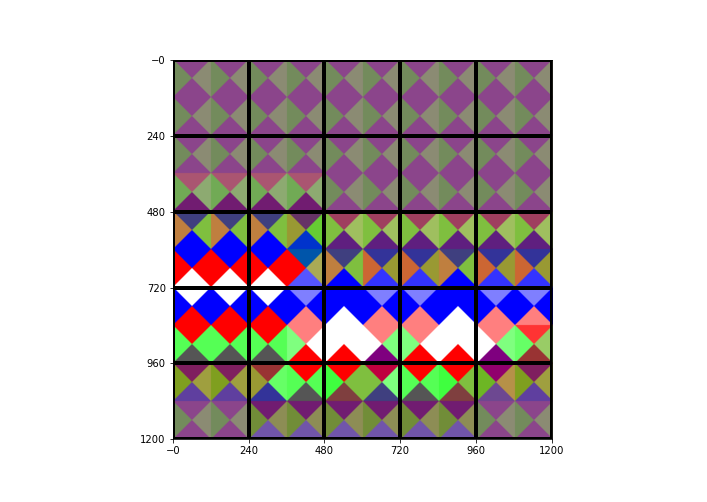

In [ ]:
animate_images(AllWaves, GridLines=120*2, LineColor='black');

## Automatic Tile and Rule Inference from Sample Image

In [ ]:
# https://github.com/mxgmn/WaveFunctionCollapse
# https://raw.githubusercontent.com/mxgmn/WaveFunctionCollapse/master/images/wfc.png

In [ ]:
from pathlib import Path
import cv2

In [ ]:
ROOT = Path('./data/Samples')

In [ ]:
# Sample = ROOT/'CavesSample.png'
# Sample = ROOT/'CitySample.png'
# Sample = ROOT/'FlowersSample.png'
# Sample = ROOT/'HousesSample.png'
Sample = ROOT/'MazeSample.png'
Sample.is_file()

True

In [ ]:
TileSize = 3
Deduplicate = True

In [ ]:
SampleImage = cv2.imread(Sample.as_posix())
# For some reason cv loads colors as BGR in this case? Swap them here to get RGB.
SampleImage[:, :, [0, 2]] = SampleImage[:, :, [2, 0]]
SampleX, SampleY, Channels = SampleImage.shape; SampleX, SampleY, Channels

(8, 8, 3)

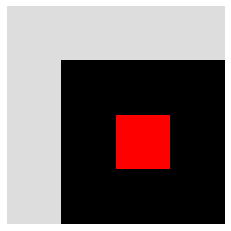

In [ ]:
show_image(SampleImage)

In [ ]:
OverhangX = SampleX % TileSize
OverhangY = SampleY % TileSize
Tiles = list()
for OffsetX in range(TileSize):
    for OffsetY in range (TileSize):
        ToX    = SampleX - OverhangX + OffsetX
        if ToX > SampleX: ToX -= TileSize # Works as long as 0 <= Offset <= TileSize
        ToY    = SampleY - OverhangY + OffsetY
        if ToY > SampleY: ToY -= TileSize # Works as long as 0 <= Offset <= TileSize

        NrTilesX = (ToX - OffsetX) // TileSize
        NrTilesY = (ToY - OffsetY) // TileSize
        
        for T in SampleImage[OffsetX:ToX, OffsetY:ToY].reshape(NrTilesX, TileSize,
                                                               NrTilesY, TileSize, Channels).swapaxes(1, 2):
            if Deduplicate:
                for T2 in T:
                    for T3 in Tiles: # NOTE: Deduplicate Tiles
                        if np.allclose(T2, T3): break
                    else: Tiles.append(T2)
            else: Tiles.extend(T)
TilesMatrix = np.array(Tiles)
TilesMatrix.shape

(24, 3, 3, 3)

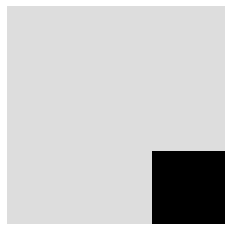

In [ ]:
show_image(Tiles[0])

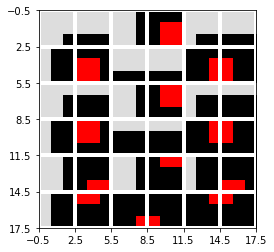

In [ ]:
# NOT DEDUPLICATED
show_image(assemble_tiles(TilesMatrix.reshape(6, 6, 3, 3, 3), GridLines=TileSize, LineColor='white')

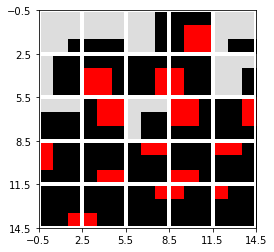

In [ ]:
# DEDUPLICATED
TilesMatrixPadded = np.stack([*TilesMatrix, TilesMatrix[-1]], axis=0) # Padding to make a square number of tiles
show_image(assemble_tiles(TilesMatrixPadded.reshape(5, 5, 3, 3, 3)), GridLines=TileSize, LineColor='white')

In [ ]:
# TODO: Figure out the neighbourhood rules from the original image
#       Find the places where each tile appears in the original image,
#       and then check which tiles appear as its neighbours.
#       Maybe this information can be recorded as part of the tile extraction process.

# TODO: Figure out how to handle wrapping around edges.
#       Maybe I can just paste on (Tilesize - 1) pixels to each side and then run the normal non-wrapping code